# Modules Import

In [ ]:
import numpy as np
import pandas as pd
from scipy.cluster.vq import kmeans2
from scipy.stats import boxcox

from statsmodels.tsa.seasonal import STL
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

from statsmodels.tsa.holtwinters import ExponentialSmoothing
from pmdarima.arima import AutoARIMA
from pmdarima.pipeline import Pipeline
from pmdarima.preprocessing import BoxCoxEndogTransformer

from sklearn.metrics import root_mean_squared_log_error, mean_absolute_percentage_error

import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objects as go

import warnings
warnings.filterwarnings('ignore')

In [2]:
# !pip freeze | grep stats

# Data visualization

## train

In [3]:
# 54 stores
# 33 product families
# 1684 days

train = pd.read_csv('train.csv', engine='pyarrow', index_col='id', parse_dates=['date'])
val = train[train['date'] >= pd.to_datetime('2017-08-01')].copy()
train = train[train['date'] < pd.to_datetime('2017-08-01')].copy()
train.head()

,date,store_nbr,family,sales,onpromotion
id,,,,,
0,2013-01-01,1,AUTOMOTIVE,0.0,0
1,2013-01-01,1,BABY CARE,0.0,0
2,2013-01-01,1,BEAUTY,0.0,0
3,2013-01-01,1,BEVERAGES,0.0,0
4,2013-01-01,1,BOOKS,0.0,0


In [4]:
temp = train[(train['store_nbr'] == 1) & (train['family'] == 'BEVERAGES')]
px.line(data_frame=temp, x='date', y=['sales', 'onpromotion'])

## test

In [5]:
# 54 stores
# 33 product families
# 16 days
# save id and predicted sales to sample_submission.csv

test = pd.read_csv('test.csv', engine='pyarrow', index_col='id', parse_dates=['date'])
test.head()

,date,store_nbr,family,onpromotion
id,,,,
3000888,2017-08-16,1,AUTOMOTIVE,0
3000889,2017-08-16,1,BABY CARE,0
3000890,2017-08-16,1,BEAUTY,2
3000891,2017-08-16,1,BEVERAGES,20
3000892,2017-08-16,1,BOOKS,0


## oil

In [6]:
oil = (train[['date']].merge(pd.read_csv('oil.csv', engine='pyarrow', parse_dates=['date']), 
                             on='date', 
                             how='left')
                      .drop_duplicates())
px.line(data_frame=oil, x='date', y='dcoilwtico')

## holidays

In [7]:
# wages in the public sector are paid every two weeks on the 15 th and on the last day of the month
# a magnitude 7.8 earthquake struck Ecuador on April 16, 2016

holidays = (pd.read_csv('holidays_events.csv', engine='pyarrow', parse_dates=['date'])
              .drop(columns=['description'])
              .drop_duplicates()) 
holidays.head()

,date,type,locale,locale_name,transferred
0,2012-03-02,Holiday,Local,Manta,False
1,2012-04-01,Holiday,Regional,Cotopaxi,False
2,2012-04-12,Holiday,Local,Cuenca,False
3,2012-04-14,Holiday,Local,Libertad,False
4,2012-04-21,Holiday,Local,Riobamba,False


## transactions

In [8]:
transactions = pd.read_csv('transactions.csv', engine='pyarrow', parse_dates=['date'])
transactions.head()

,date,store_nbr,transactions
0,2013-01-01,25,770
1,2013-01-02,1,2111
2,2013-01-02,2,2358
3,2013-01-02,3,3487
4,2013-01-02,4,1922


In [9]:
temp = transactions[transactions['store_nbr'] == 1]
px.line(data_frame=temp, x='date', y='transactions')

## stores

In [10]:
stores = pd.read_csv('stores.csv', engine='pyarrow')
stores.head()

,store_nbr,city,state,type,cluster
0,1,Quito,Pichincha,D,13
1,2,Quito,Pichincha,D,13
2,3,Quito,Pichincha,D,8
3,4,Quito,Pichincha,D,9
4,5,Santo Domingo,Santo Domingo de los Tsachilas,D,4


In [11]:
stores['store_nbr'].value_counts().size, stores['cluster'].value_counts().size, stores['type'].value_counts().size

(54, 17, 5)

# Data preparation

## family clustering

In [12]:
temp = train[train['date'] >= pd.to_datetime('2016-07-31')]
train = pd.DataFrame([])

t = temp[['store_nbr', 'family']].drop_duplicates()
for store, family in zip(t['store_nbr'], t['family']):
    train = pd.concat([train, (temp[(temp['store_nbr'] == store) & (temp['family'] == family)]
                                    .merge(pd.DataFrame({'date': pd.date_range(start='2016-07-31', end='2017-07-31')}),
                                        on='date', how='right')
                                    .apply(lambda x: x if x.name == 'date' else 
                                                    (x.fillna(method='bfill') if x.name in ['store_nbr', 'family'] else
                                                     x.interpolate(method='linear'))
                                          ))
                      ])

temp = (train.merge(stores[['store_nbr', 'cluster']], on='store_nbr')
             .rename(columns={'cluster': 'store_cluster'})
             .groupby(['date', 'store_cluster', 'family'])[['sales', 'onpromotion']].sum()
             .reset_index())
temp.head()

,date,store_cluster,family,sales,onpromotion
0,2016-07-31,1,AUTOMOTIVE,13.0,0.0
1,2016-07-31,1,BABY CARE,0.0,0.0
2,2016-07-31,1,BEAUTY,25.0,2.0
3,2016-07-31,1,BEVERAGES,10807.0,19.0
4,2016-07-31,1,BOOKS,0.0,0.0


In [13]:
for cluster in temp['store_cluster'].unique():
    tmp = (temp[temp['store_cluster'] == cluster]
           .pivot_table(index='date', columns='family', values='sales')
           .agg(lambda x: pd.Series({'mean': x.mean(),
                                     'var': x.var(),
                                     'min': x.min(),
                                     'q25': x.quantile(.25),
                                     'q50': x.quantile(.5),
                                     'q75': x.quantile(.75),
                                     'max': x.max(),
                                     'roll7': x.rolling(7).mean().values[-1],
                                     'roll14': x.rolling(14).mean().values[-1],
                                     'roll21': x.rolling(21).mean().values[-1],
                                     'roll28': x.rolling(28).mean().values[-1]
                                     }))
            .T)

    temp = temp.merge(pd.DataFrame({'store_cluster': [cluster] * tmp.shape[0],
                                    'family': tmp.index,
                                    f'family_cluster_{cluster}': kmeans2(tmp, minit='points', k=3, seed=666)[-1]}), 
                                   on=['store_cluster', 'family'], how='left')

temp['family_cluster'] = temp.loc[:, 'family_cluster_1':].fillna(0).sum(axis=1).astype(int)
temp.drop(columns=temp.columns[6:-1], inplace=True)

In [14]:
clusters = (temp[['store_cluster', 'family', 'family_cluster']].drop_duplicates()
            .merge(stores[['cluster', 'store_nbr']].rename(columns={'cluster': 'store_cluster'}), on='store_cluster'))
clusters.head()

,store_cluster,family,family_cluster,store_nbr
0,1,AUTOMOTIVE,0,24
1,1,AUTOMOTIVE,0,25
2,1,AUTOMOTIVE,0,27
3,1,BABY CARE,0,24
4,1,BABY CARE,0,25


In [15]:
temp = (train[train['date'] >= (pd.to_datetime('2017-07-31') - pd.to_timedelta('16 days'))]
        .merge(clusters, on=['store_nbr', 'family']))
temp.head()

,date,store_nbr,family,sales,onpromotion,store_cluster,family_cluster
0,2017-07-15,1.0,AUTOMOTIVE,6.0,0.0,13,0
1,2017-07-16,1.0,AUTOMOTIVE,2.0,0.0,13,0
2,2017-07-17,1.0,AUTOMOTIVE,2.0,0.0,13,0
3,2017-07-18,1.0,AUTOMOTIVE,3.0,0.0,13,0
4,2017-07-19,1.0,AUTOMOTIVE,7.0,0.0,13,0


In [16]:
rate = []
for store, family, store_cluster, family_cluster in zip(clusters['store_nbr'],
                                                        clusters['family'],
                                                        clusters['store_cluster'],
                                                        clusters['family_cluster']):
    x = temp[(temp['store_nbr'] == store) & (temp['family'] == family)]['sales'].sum()
    y = temp[(temp['store_cluster'] == store_cluster) & 
             (temp['family_cluster'] == family_cluster)].groupby('date')['sales'].sum().sum()
    rate.append(x / y)

clusters['rate'] = rate
clusters.head()

,store_cluster,family,family_cluster,store_nbr,rate
0,1,AUTOMOTIVE,0,24,0.000438
1,1,AUTOMOTIVE,0,25,0.000445
2,1,AUTOMOTIVE,0,27,0.000927
3,1,BABY CARE,0,24,0.000030
4,1,BABY CARE,0,25,0.000022


In [17]:
clusters[['store_cluster', 'family_cluster']].drop_duplicates().shape

(51, 2)

## holidays features

In [18]:
temp = (holidays[holidays['type'] != 'Transfer']
        .drop(columns=['transferred'])
        .assign(flag=1)
        .pivot_table(index=['date', 'locale', 'locale_name'], 
                    columns=['type'],
                    values=['flag'])
        .fillna(0)
        .astype(int)
        .reset_index()
        .droplevel(0, axis=1))

temp.columns = ['date', 'type', 'locale'] + list(temp.columns)[3:]

temp = (temp.join((temp.reset_index()
                        .pivot_table(index='index', columns='type', values='date')
                        .replace(pd.NaT, 0)
                        .astype(bool)
                        .astype(int)))
                .drop(columns=['type']))

temp.head()

,date,locale,Additional,Bridge,Event,Holiday,Work Day,Local,National,Regional
0,2012-03-02,Manta,0,0,0,1,0,1,0,0
1,2012-04-01,Cotopaxi,0,0,0,1,0,0,0,1
2,2012-04-12,Cuenca,0,0,0,1,0,1,0,0
3,2012-04-14,Libertad,0,0,0,1,0,1,0,0
4,2012-04-21,Riobamba,0,0,0,1,0,1,0,0


In [19]:
holidays = (clusters[['store_cluster', 'store_nbr']].drop_duplicates()
            .merge(stores[['store_nbr', 'city', 'state']], on=['store_nbr'])
            .drop(columns=['store_nbr'])
            .drop_duplicates()
            .assign(country='Ecuador')
            .melt(id_vars=['store_cluster'])
            .drop(columns=['variable'])
            .rename(columns={'value': 'locale'})
            .drop_duplicates()
            .merge(temp, on='locale')
            .groupby(['store_cluster', 'date'])[temp.columns[2:]].max()
            .reset_index())

holidays.to_csv('holidays.csv', index=False)
holidays.head()

,store_cluster,date,Additional,Bridge,Event,Holiday,Work Day,Local,National,Regional
0,1,2012-08-10,0,0,0,1,0,0,1,0
1,1,2012-10-09,0,0,0,1,0,0,1,0
2,1,2012-11-02,0,0,0,1,0,0,1,0
3,1,2012-11-03,0,0,0,1,0,0,1,0
4,1,2012-11-07,0,0,0,1,0,0,0,1


## salary feature

In [961]:
salary = pd.DataFrame({'date': pd.date_range(start='2016-07-31', end='2017-08-31')})
salary['salary'] = salary['date'].apply(lambda x: (x.day == 15) | x.is_month_end).astype(int)
salary.head()

,date,salary
0,2016-07-31,1
1,2016-08-01,0
2,2016-08-02,0
3,2016-08-03,0
4,2016-08-04,0


## train data & val

In [22]:
temp = (pd.concat([train, val])
           .merge(clusters.drop(columns=['rate']), on=['store_nbr', 'family'])
           .groupby(['date', 'store_cluster', 'family_cluster'])[['sales', 'onpromotion']].sum()
           .reset_index()
           .merge((clusters[['store_nbr', 'store_cluster']].drop_duplicates()
                           .merge(transactions, on='store_nbr')
                           .groupby(['date', 'store_cluster'])['transactions'].sum()
                           .reset_index()), on=['date', 'store_cluster'], how='left'))

train, val = temp[temp['date'] < pd.to_datetime('2017-08-01')], \
             temp[temp['date'] >= pd.to_datetime('2017-08-01')]
train.head()

,date,store_cluster,family_cluster,sales,onpromotion,transactions
0,2016-07-31,1,0,8682.17898,50.0,4573.0
1,2016-07-31,1,1,31231.04800,144.0,4573.0
2,2016-07-31,1,2,6858.93500,41.0,4573.0
3,2016-07-31,2,0,4152.61400,34.0,2183.0
4,2016-07-31,2,1,15172.06300,107.0,2183.0


In [23]:
temp = train[(train['store_cluster'] == 1) & (train['family_cluster'] == 0)]
px.line(data_frame=temp, x='date', y=['sales', 'onpromotion', 'transactions'])

## transaction feature

### analytics on a specific store_cluster (as an example)

In [24]:
temp = train[train['store_cluster'] == 14][['date', 'transactions']].drop_duplicates()
temp['transactions'] = temp['transactions'].interpolate(method='pchip')
temp_val = val[val['store_cluster'] == 14][['date', 'transactions']].drop_duplicates()

px.line(data_frame=pd.concat([temp.assign(data='train'), temp_val.assign(data='val')]), 
        x='date', 
        y=['transactions'],
        color='data')

In [25]:
adfuller(temp['transactions'])[:2]

(-3.5716913153241046, 0.006325870817587098)

In [26]:
l = []
for x in np.arange(7, 91, 7):
    stl = STL(temp['transactions'], period=x).fit()
    l.append((x, 1 - stl.resid.var(ddof=1) / (stl.seasonal + stl.resid).var(ddof=1)))
l.sort(key=lambda x: x[-1], reverse=True)
l[0]

(7, 0.8967950947060827)

In [27]:
p = 7
stl = STL(temp['transactions'], period=p).fit()
plot = make_subplots(3)

plot.add_trace(go.Scatter(x=temp['date'], y=stl.trend, mode='lines', name='trend'), row=1, col=1)
plot.add_trace(go.Scatter(x=temp['date'], y=stl.seasonal, mode='lines', name='seasonal'), row=2, col=1)
plot.add_trace(go.Scatter(x=temp['date'], y=stl.resid, mode='lines', name='resid'), row=3, col=1)

### Holt Winter's model

In [28]:
model = ExponentialSmoothing(endog=temp['transactions'], trend='add', seasonal='add', use_boxcox=True,
                                seasonal_periods=7).fit(optimized=True)
temp_val['pred'] = model.forecast(15).values
px.line(data_frame=temp_val.melt(id_vars='date'), x='date', y='value', color='variable')

In [29]:
(root_mean_squared_log_error(temp_val['transactions'], temp_val['pred']), 
 mean_absolute_percentage_error(temp_val['transactions'], temp_val['pred']))

(0.09705244554488945, 0.0807846735765161)

### modeling

In [30]:
transaction_models, mape_list, train_filled_trans = {}, [], pd.DataFrame([])
for cluster in train['store_cluster'].unique():
    temp = train[train['store_cluster'] == cluster][['store_cluster', 'date', 'transactions']].drop_duplicates()
    temp['transactions'] = temp['transactions'].interpolate(method='pchip')
    train_filled_trans = pd.concat([train_filled_trans, temp])
    temp_val = val[val['store_cluster'] == cluster][['date', 'transactions']].drop_duplicates()    
    
    model = ExponentialSmoothing(endog=temp['transactions'], trend='add', seasonal='add', use_boxcox=True,
                                 seasonal_periods=7).fit(optimized=True)
    transaction_models[cluster] = model
    temp_val['trans_pred'] = transaction_models.get(cluster).forecast(15).values
    mape_list.append(mean_absolute_percentage_error(temp_val['transactions'], temp_val['trans_pred']))
pd.Series(mape_list, name='mape').describe()

count    17.000000
mean      0.058778
std       0.015430
min       0.038507
25%       0.050953
50%       0.055531
75%       0.063466
max       0.098127
Name: mape, dtype: float64

In [31]:
trans_val_pred = pd.DataFrame([])

for cluster in val['store_cluster'].unique():
    temp = val[val['store_cluster'] == cluster][['store_cluster', 'date', 'transactions']].drop_duplicates()
    temp['transactions'] = transaction_models.get(cluster).forecast(15).values
    trans_val_pred = pd.concat([trans_val_pred, temp])

train = train.drop(columns=['transactions']).merge(train_filled_trans, on=['date', 'store_cluster'])
val = val.drop(columns=['transactions']).merge(trans_val_pred, on=['date', 'store_cluster'])
val.head()

,date,store_cluster,family_cluster,sales,onpromotion,transactions
0,2017-08-01,1,0,7980.299,67.0,4369.205742
1,2017-08-01,1,1,27354.862,242.0,4369.205742
2,2017-08-01,1,2,6034.795,50.0,4369.205742
3,2017-08-01,2,0,5210.268,61.0,2419.427248
4,2017-08-01,2,1,22442.778,173.0,2419.427248


## oil feature

### analytics

In [32]:
oil = (pd.concat([train, val])[['date']]
         .drop_duplicates()
         .merge(pd.read_csv('oil.csv', parse_dates=['date']),
                on='date', how='left'))
oil['dcoilwtico'] = oil['dcoilwtico'].interpolate(method='polynomial', order=3).fillna(method='bfill')
train_oil, val_oil = oil[oil['date'] < pd.to_datetime('2017-08-01')].copy(), \
                     oil[oil['date'] >= pd.to_datetime('2017-08-01')].copy()
train_oil.head()

,date,dcoilwtico
0,2016-07-31,40.05
1,2016-08-01,40.05
2,2016-08-02,39.50
3,2016-08-03,40.80
4,2016-08-04,41.92


In [33]:
px.line(data_frame=pd.concat([train_oil.assign(data='train'), val_oil.assign(data='val')]), 
        x='date', y='dcoilwtico', color='data')

In [34]:
adfuller(train_oil['dcoilwtico'].dropna())[:2]

(-3.0218744610385184, 0.03290148466533473)

In [35]:
l = []
for x in np.arange(7, 91, 7):
    stl = STL(train_oil['dcoilwtico'], period=x).fit()
    l.append((x, 1 - stl.resid.var(ddof=1) / (stl.seasonal + stl.resid).var(ddof=1)))
l.sort(key=lambda x: x[-1], reverse=True)
l[0]

(56, 0.6227200963923054)

In [36]:
p = 56
stl = STL(train_oil['dcoilwtico'], period=p).fit()
plot = make_subplots(3)

plot.add_trace(go.Scatter(x=train_oil['date'], y=stl.trend, mode='lines', name='trend'), row=1, col=1)
plot.add_trace(go.Scatter(x=train_oil['date'], y=stl.seasonal, mode='lines', name='seasonal'), row=2, col=1)
plot.add_trace(go.Scatter(x=train_oil['date'], y=stl.resid, mode='lines', name='resid'), row=3, col=1)

### Holt Winter's model

In [37]:
model = ExponentialSmoothing(endog=train_oil['dcoilwtico'], trend='add', seasonal='add', use_boxcox=True,
                                seasonal_periods=56).fit(optimized=True)
val_oil['pred'] = model.forecast(15).values
px.line(data_frame=val_oil.melt(id_vars='date'), x='date', y='value', color='variable')

In [38]:
(root_mean_squared_log_error(val_oil['dcoilwtico'], val_oil['pred']), 
 mean_absolute_percentage_error(val_oil['dcoilwtico'], val_oil['pred']))

(0.013098179388362514, 0.011150583065217436)

### modeling

In [42]:
train_oil.rename(columns={'dcoilwtico': 'oil'}, inplace=True)
oil_model = ExponentialSmoothing(endog=train_oil['oil'], trend='add', seasonal='add', use_boxcox=True,
                                 seasonal_periods=56).fit(optimized=True)
val_oil['oil'] = model.forecast(15).values
val_oil.drop(columns=['dcoilwtico', 'pred'], inplace=True)

## shifting transactions and oil to yesterday

In [43]:
temp = pd.concat([train.merge(train_oil, on='date'), val.merge(val_oil, on='date')])
temp = (temp.sort_values(['store_cluster', 'family_cluster'])
            .reset_index(drop=True)
            .drop(columns=['transactions', 'oil'])
            .join((temp.groupby(['store_cluster', 'family_cluster'])[['transactions', 'oil']]
                        .apply(lambda x: x.shift().fillna(method='bfill'))
                        .reset_index(drop=True)))
        )

train, val = temp[temp['date'] < pd.to_datetime('2017-08-01')], temp[temp['date'] >= pd.to_datetime('2017-08-01')]
train.head()

,date,store_cluster,family_cluster,sales,onpromotion,transactions,oil
0,2016-07-31,1,0,8682.178980,50.0,4573.0,40.05
1,2016-08-01,1,0,7560.776001,30.0,4573.0,40.05
2,2016-08-02,1,0,6739.126001,55.0,4448.0,40.05
3,2016-08-03,1,0,7488.350000,52.0,4461.0,39.50
4,2016-08-04,1,0,6094.087977,67.0,4710.0,40.80


# Sales modeling

## modeling on a specific store_cluster and family_cluster (as an example)

### analytics

In [795]:
train_temp = (train[(train['store_cluster'] == 2) & (train['family_cluster'] == 1)]
             .merge(holidays, on=['date', 'store_cluster'], how='left')
             .fillna(0)
             .merge(salary, on='date')
             .set_index('date')
             .asfreq('D'))

val_temp = (val[(val['store_cluster'] == 2) & (val['family_cluster'] == 1)]
             .merge(holidays, on=['date', 'store_cluster'], how='left')
             .fillna(0)
             .merge(salary, on='date')
             .set_index('date')
             .asfreq('D'))

train_temp.head()

,store_cluster,family_cluster,sales,onpromotion,transactions,oil,Additional,Bridge,Event,Holiday,Work Day,Local,National,Regional,salary
date,,,,,,,,,,,,,,,
2016-07-31,2,1,15172.063,107.0,2183.0,40.05,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
2016-08-01,2,1,19677.481,92.0,2183.0,40.05,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
2016-08-02,2,1,16518.464,92.0,2498.0,40.05,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
2016-08-03,2,1,18572.018,497.0,2494.0,39.50,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
2016-08-04,2,1,14746.938,116.0,2515.0,40.80,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0


In [796]:
adfuller(train_temp['sales'])[:2]

(-2.8617509895327538, 0.04998005878777302)

In [797]:
l = []
for x in np.arange(7, 91, 7):
    stl = STL(train_temp['sales'], period=x).fit()
    l.append((x, 1 - stl.resid.var(ddof=1) / (stl.seasonal + stl.resid).var(ddof=1)))
l.sort(key=lambda x: x[-1], reverse=True)
l[0]

(7, 0.6987933108235651)

In [798]:
p = 7
stl = STL(train_temp['sales'], period=p).fit()
plot = make_subplots(3)

plot.add_trace(go.Scatter(x=train_temp.index, y=stl.trend, mode='lines', name='trend'), row=1, col=1)
plot.add_trace(go.Scatter(x=train_temp.index, y=stl.seasonal, mode='lines', name='seasonal'), row=2, col=1)
plot.add_trace(go.Scatter(x=train_temp.index, y=stl.resid, mode='lines', name='resid'), row=3, col=1)

### SARIMAX model

In [801]:
train_temp['sales_boxcox'] = boxcox(train_temp['sales'] + 1, .1)
px.line(data_frame=train_temp, y='sales_boxcox')

In [802]:
train_temp['sales_boxcox_diff_7'] = train_temp['sales_boxcox'].diff(7)
px.line(x=train_temp.index, y=train_temp['sales_boxcox_diff_7'])

In [803]:
adfuller(train_temp['sales_boxcox_diff_7'].diff().dropna())[:2]

(-9.295321651031234, 1.1503092185240565e-15)

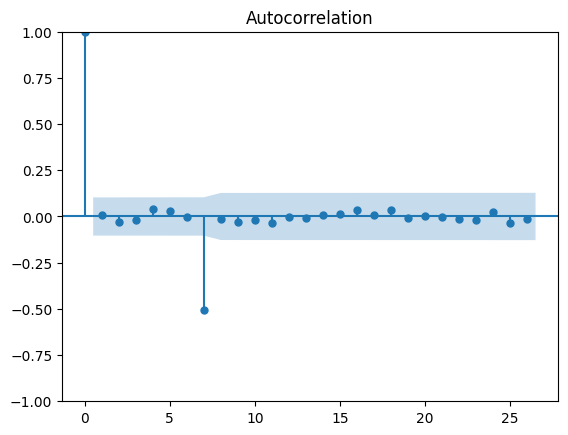

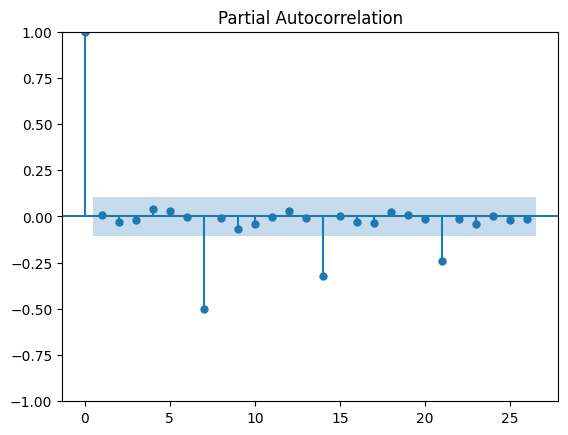

In [804]:
q = plot_acf(train_temp['sales_boxcox_diff_7'].dropna())
p = plot_pacf(train_temp['sales_boxcox_diff_7'].dropna())

In [805]:
adfuller(train_temp['sales_boxcox'].diff().fillna(method='bfill'))[:2]

(-9.408512113237668, 5.921522935237767e-16)

In [806]:
train_temp['sales_boxcox_diff_7_1'] = train_temp['sales_boxcox_diff_7'].diff()
px.line(x=train_temp.index, y=train_temp['sales_boxcox_diff_7_1'])

In [807]:
adfuller(train_temp['sales_boxcox_diff_7_1'].diff().dropna())[:2]

(-9.550309801366495, 2.582497593608871e-16)

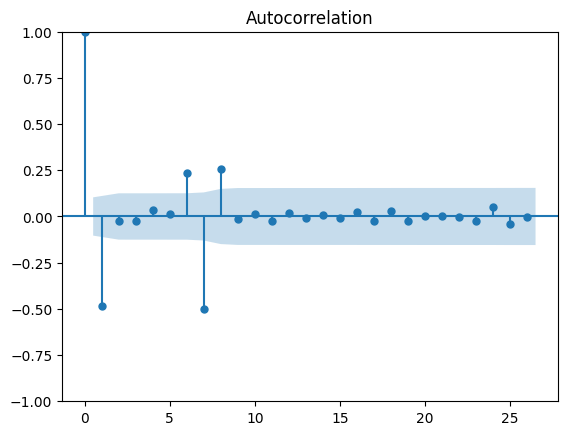

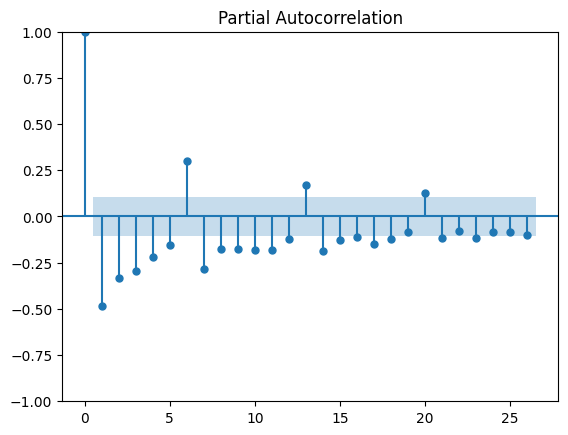

In [808]:
q = plot_acf(train_temp['sales_boxcox_diff_7_1'].dropna())
p = plot_pacf(train_temp['sales_boxcox_diff_7_1'].dropna())

In [809]:
model = Pipeline([('boxcox', BoxCoxEndogTransformer(lmbda=.1, lmbda2=1)),
                  ('sarimax', AutoARIMA(start_p=0, start_q=0, d=1, 
                                        start_P=0, start_Q=0, D=1,
                                        m=7))
                 ])
model.fit(train_temp['sales'], X=train_temp.loc[:,'onpromotion':'salary'])

,steps,"[('boxcox', ...), ('sarimax', ...)]"


In [810]:
val_temp['pred'] = model.predict(n_periods=15, X=val_temp.loc[:,'onpromotion':'salary'])
px.line(data_frame=val_temp.reset_index()[['date', 'sales', 'pred']].melt(id_vars='date'), 
        x='date', y='value', color='variable')

In [811]:
(root_mean_squared_log_error(val_temp['sales'], val_temp['pred']), 
 mean_absolute_percentage_error(val_temp['sales'], val_temp['pred']))

(0.44095616224554424, 0.2834926497425419)

### fact val sample evaluation

In [812]:
fact_val = pd.read_csv('train.csv', engine='pyarrow', index_col='id', parse_dates=['date'])
fact_val = (fact_val[fact_val['date'] >= pd.to_datetime('2017-08-01')]
                    .merge(clusters, on=['store_nbr', 'family']))
fact_val.head()

,date,store_nbr,family,sales,onpromotion,store_cluster,family_cluster,rate
0,2017-08-01,1,AUTOMOTIVE,5.0,0,13,0,0.000543
1,2017-08-01,1,BABY CARE,0.0,0,13,0,0.000000
2,2017-08-01,1,BEAUTY,4.0,0,13,0,0.000320
3,2017-08-01,1,BEVERAGES,2627.0,26,13,1,0.057132
4,2017-08-01,1,BOOKS,0.0,0,13,0,0.000013


In [813]:
fact_val_temp = (fact_val[(fact_val['store_cluster'] == 1) & (fact_val['family_cluster'] == 0)]
                         .set_index('date')
                         .join(val_temp['pred']))
fact_val_temp['sales_pred'] = fact_val_temp['pred'] * fact_val_temp['rate']
fact_val_temp.head()

,store_nbr,family,sales,onpromotion,store_cluster,family_cluster,rate,pred,sales_pred
date,,,,,,,,,
2017-08-01,24,AUTOMOTIVE,3.000,0,1,0,0.000438,14005.85105,6.128094
2017-08-01,24,BABY CARE,1.000,0,1,0,0.000030,14005.85105,0.415464
2017-08-01,24,BEAUTY,4.000,0,1,0,0.000645,14005.85105,9.036343
2017-08-01,24,BOOKS,0.000,0,1,0,0.000000,14005.85105,0.000000
2017-08-01,24,BREAD/BAKERY,735.021,0,1,0,0.091265,14005.85105,1278.243651


In [814]:
root_mean_squared_log_error(fact_val_temp['sales'], fact_val_temp['sales_pred'])

0.6008486904722643

In [821]:
t = (fact_val_temp[(fact_val_temp['store_nbr'] == 25) & (fact_val_temp['family'] == 'BREAD/BAKERY')]
                  [['sales', 'sales_pred']])
px.line(data_frame=t.reset_index()[['date', 'sales', 'sales_pred']].melt(id_vars='date'), 
        x='date', y='value', color='variable')

In [822]:
(root_mean_squared_log_error(t['sales'], t['sales_pred']), 
 mean_absolute_percentage_error(t['sales'], t['sales_pred']))

(0.46365684016369824, 0.4245898173092642)

## final modeling

In [823]:
temp = (pd.concat([train, val])
          .merge(holidays, on=['date', 'store_cluster'], how='left')
          .fillna(0)
          .merge(salary, on='date'))
temp.head()

,date,store_cluster,family_cluster,sales,onpromotion,transactions,oil,Additional,Bridge,Event,Holiday,Work Day,Local,National,Regional,salary
0,2016-07-31,1,0,8682.178980,50.0,4573.0,40.05,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
1,2016-08-01,1,0,7560.776001,30.0,4573.0,40.05,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
2,2016-08-02,1,0,6739.126001,55.0,4448.0,40.05,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
3,2016-08-03,1,0,7488.350000,52.0,4461.0,39.50,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
4,2016-08-04,1,0,6094.087977,67.0,4710.0,40.80,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0


In [ ]:
sales_models, unique_clusters = {}, clusters[['store_cluster', 'family_cluster']].drop_duplicates()
tmp_val_pred = pd.DataFrame([])

j = 1
for x, y in zip(unique_clusters['store_cluster'], unique_clusters['family_cluster']):
    tmp = (temp[(temp['store_cluster'] == x) & (temp['family_cluster'] == y)]
                .assign(sample=lambda x: (x.date < pd.to_datetime('2017-08-01')).astype(int))
                .set_index('date')
                .asfreq('D'))
    
    model = Pipeline([('boxcox',  BoxCoxEndogTransformer(lmbda=.1, lmbda2=1)),
                      ('sarimax', AutoARIMA(start_p=0, start_q=0, d=1,
                                            start_P=0, start_Q=0, D=1,
                                            m=7))
                     ])
    model.fit(tmp[tmp['sample'] == 1]['sales'], 
              X=tmp[tmp['sample'] == 1].loc[:,'onpromotion':'salary'])
    sales_models[(x, y)] = model

    tmp_val_pred = pd.concat([tmp_val_pred,
                              (tmp[tmp['sample'] == 0][['store_cluster', 'family_cluster', 'sales']]
                                  .assign(pred=sales_models.get((x, y)).predict(n_periods=15, 
                                          X=tmp[tmp['sample'] == 0].loc[:,'onpromotion':'salary']))
                                  .reset_index())])
    
    print(f'{j}/51', end='\r')
    j += 1

final_val_pred = (fact_val.merge(tmp_val_pred.drop(columns=['sales']), 
                                 on=['date', 'store_cluster', 'family_cluster'])
                          .assign(sales_pred=lambda x: x.rate * x.pred))
final_val_pred.head()

,date,store_nbr,family,sales,onpromotion,store_cluster,family_cluster,rate,pred,sales_pred
0,2017-08-01,1,AUTOMOTIVE,5.0,0,13,0,0.000543,7162.387675,3.887919
1,2017-08-01,1,BABY CARE,0.0,0,13,0,0.000000,7162.387675,0.000000
2,2017-08-01,1,BEAUTY,4.0,0,13,0,0.000320,7162.387675,2.295277
3,2017-08-01,1,BEVERAGES,2627.0,26,13,1,0.057132,27682.458232,1581.544121
4,2017-08-01,1,BOOKS,0.0,0,13,0,0.000013,7162.387675,0.093685


In [837]:
root_mean_squared_log_error(final_val_pred['sales'], final_val_pred['sales_pred'])

0.5654554425412914

In [873]:
t = (final_val_pred[(final_val_pred['store_nbr'] == 13) & (final_val_pred['family'] == 'EGGS')]
                  [['date', 'sales', 'sales_pred']])
px.line(data_frame=t.melt(id_vars='date'), x='date', y='value', color='variable')

# Test submit

In [981]:
tmp = (test.merge(clusters, on=['store_nbr', 'family'])
            .groupby(['date', 'store_cluster', 'family_cluster'])['onpromotion'].sum()
            .reset_index())

tmp = (pd.concat([tmp, 
                  (clusters[['store_cluster', 'family_cluster']].drop_duplicates()
                           .assign(date=pd.to_datetime('2017-08-15')))])
        .reset_index(drop=True)
        .sort_values(['date', 'store_cluster', 'family_cluster']))

test_trans_pred = pd.DataFrame([])
for cluster in tmp['store_cluster'].unique():
    test_trans_pred = pd.concat([test_trans_pred, 
                                 pd.DataFrame({'date': tmp['date'].unique(),
                                               'store_cluster': cluster,
                                               'transactions': transaction_models.get(cluster).forecast(31).tail(17)})])
    
tmp = (tmp.merge(test_trans_pred, on=['date', 'store_cluster'])
          .merge(pd.DataFrame({'date': tmp['date'].unique(),
                               'oil': oil_model.forecast(31).tail(17)
                               }), on=['date']))

tmp = (tmp.sort_values(['store_cluster', 'family_cluster'])
            .reset_index(drop=True)
            .drop(columns=['transactions', 'oil'])
            .join((tmp.groupby(['store_cluster', 'family_cluster'])[['transactions', 'oil']]
                    .apply(lambda x: x.shift())
                    .reset_index(drop=True)))
            .dropna())

tmp = pd.concat([(val.merge(holidays, on=['date', 'store_cluster'], how='left')
                     .fillna(0)
                     .merge(salary, on='date')
                     .drop(columns=['sales'])),   
                 (tmp.merge(holidays, on=['date', 'store_cluster'], how='left')
                     .merge(salary, on='date')
                     .fillna(0)),
                ])

tmp.head()

,date,store_cluster,family_cluster,onpromotion,transactions,oil,Additional,Bridge,Event,Holiday,Work Day,Local,National,Regional,salary
0,2017-08-01,1,0,67.0,4608.000000,50.210000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
1,2017-08-02,1,0,115.0,4369.205742,50.221084,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
2,2017-08-03,1,0,107.0,4745.796696,49.291761,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
3,2017-08-04,1,0,616.0,4445.840620,49.379637,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
4,2017-08-05,1,0,110.0,5095.218048,49.428626,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0


In [1003]:
tmp_test_pred = pd.DataFrame([])

for x, y in zip(unique_clusters['store_cluster'], unique_clusters['family_cluster']):
    t = tmp[(tmp['store_cluster'] == x) & (tmp['family_cluster'] == y)]
    t['pred'] = sales_models.get((x, y)).predict(n_periods=31, 
                                                 X=t.loc[:, 'onpromotion':'salary'])
    tmp_test_pred = pd.concat([tmp_test_pred,
                               t.tail(16)[['date', 'store_cluster', 'family_cluster', 'pred']]])

fact_test_pred = (tmp_test_pred.merge(clusters, on=['store_cluster', 'family_cluster'])
                               .assign(sales_pred=lambda x: x.rate * x.pred)
                               [['date', 'store_nbr', 'family', 'sales_pred']])

fact_test_pred.head()

,date,store_nbr,family,sales_pred
0,2017-08-16,24,AUTOMOTIVE,4.232313
1,2017-08-16,25,AUTOMOTIVE,4.304047
2,2017-08-16,27,AUTOMOTIVE,8.966764
3,2017-08-16,24,BABY CARE,0.286936
4,2017-08-16,25,BABY CARE,0.215202


In [ ]:
sample_submission = pd.read_csv('sample_submission.csv')
sample_submission['sales'] = test.merge(fact_test_pred, on=['date', 'store_nbr', 'family'])['sales_pred'].values
sample_submission.head()

In [ ]:
# !kaggle competitions submit -c store-sales-time-series-forecasting -f submission.csv -m "Message"

In [1031]:
sample_submission.to_csv('sample_submission.csv', index=False)